In [1]:
SEED = 61


import os
import re
import gc
import h5py
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from tqdm import tqdm
from nltk import tokenize

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import display_html

from keras import backend as K
from keras import initializers,regularizers,constraints
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPool2D, Convolution2D
from keras.layers.core import RepeatVector, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import cross_val_score

def reset_seeds():
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

# from tensorflow.python.keras.layers import Layer, InputSpec, Lambda
# from tensorflow.keras import Model
# from attention import Attention_input1, Attention_input2
# from keras.optimizers import SGD, RMSprop, Adagrad

In [2]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')

    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

In [3]:
def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]

    return labels, text_labels, image_labels

def load_mvsa_feature(feature_name, merge=False):
    folder_path = os.path.join('../input/mvsa-features/', feature_name)
    single_file = 'mvsa-single-{}.npz'.format(feature_name)
    multiple_file = 'mvsa-multiple-{}.npz'.format(feature_name)
    mvsa_single = loadz(os.path.join(folder_path, single_file))
    mvsa_multiple = loadz(os.path.join(folder_path, multiple_file))
    
    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)
    
    return mvsa_single, mvsa_multiple

def load_mvsa_images(merge=False):
    folder_path = '../input/mvsa-data'
    file_paths = os.listdir(folder_path)
    for path in file_paths:
        file_name = os.path.split(path)[1]
        if file_name.split('.')[1] == 'npz':
            if file_name.split('-')[1] == 'single':
                mvsa_single_images_path = os.path.join(folder_path, path)
            else:
                mvsa_multiple_images_path = os.path.join(folder_path, path)
    
    mvsa_single = loadz(mvsa_single_images_path)
    mvsa_multiple = loadz(mvsa_multiple_images_path)
    
    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)
    
    return mvsa_single, mvsa_multiple

def merge_mvsa(mvsa_single, mvsa_multiple):
    mvsa = np.concatenate((mvsa_single, mvsa_multiple), axis=0)
    return mvsa

In [4]:
def plot_metrics(history):
    fig = plt.figure(figsize=(20, 5))

    fig.add_subplot(1, 4, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 4, 3)
    plt.plot(history.history['f1_macro'])
    plt.plot(history.history['val_f1_macro'])
    plt.title('Macro F1-SCORE')
    plt.ylabel('f1-macro')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
    
    fig.add_subplot(1, 4, 4)
    plt.plot(history.history['f1_weighted'])
    plt.plot(history.history['val_f1_weighted'])
    plt.title('Weighted F1-SCORE')
    plt.ylabel('f1-weighted')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    plt.show()

In [5]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * len(data))
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_tf_data(data, validation_split):
    DATASET_SIZE = len(data)
    train_size = int((1-validation_split*2) * DATASET_SIZE)
    val_size = int(validation_split * DATASET_SIZE)
    test_size = int(validation_split * DATASET_SIZE)

#     full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
#     full_dataset = full_dataset.shuffle()
    train_dataset = data.take(train_size)
    test_dataset = data.skip(train_size)
    val_dataset = test_dataset.skip(test_size)
    test_dataset = test_dataset.take(test_size)
    return train_dataset, val_dataset, test_dataset

In [6]:
def create_model_cnn(input_shape):
    f1_macro = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', name='f1_macro')
    f1_weighted = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='weighted', name='f1_weighted')

    image_inputs = Input(shape=input_shape)
#     x = Reshape((1, input_shape[0], input_shape[1], input_shape[2])) (image_inputs)
    x = Convolution2D(32, kernel_size=(5,5), strides=(1,1), activation='relu') (image_inputs)
#     x = Reshape((x.shape[2], x.shape[3], x.shape[4])) (x)
    x = MaxPool2D(pool_size=(2,2)) (x)
    x = Convolution2D(64, kernel_size=(5,5), strides=(1,1), activation='relu') (x)
    x = MaxPool2D(pool_size=(2,2)) (x)
    x = Convolution2D(128, kernel_size=(5,5), strides=(1,1), activation='relu') (x)
    x = MaxPool2D(pool_size=(2,2)) (x)
    x = Flatten() (x)
    x = Dense(64, activation='relu') (x)
    outputs = Dense(NUM_CLASSES, activation='softmax') (x)

    model = Model(image_inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_macro, f1_weighted])
    return model

In [7]:
def run_and_evaluate(name, X, y, verbose=0):
    y = le.fit_transform(y)
    y = to_categorical(np.asarray(y))
    
    X_train, X_val, X_test = split_data(X, VALIDATION_SPLIT)
    y_train, y_val, y_test = split_data(y, VALIDATION_SPLIT)
    
    model = create_model_pretrained(X_train.shape[1:])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    checkpoint = ModelCheckpoint('./model_checkpoint/{}.h5'.format(name), save_best_only=True, verbose=verbose)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                   epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose,
                                   callbacks=[checkpoint, early_stopping])
    if verbose == 1:
        best_epoch = np.argmin(history.history['val_loss'])
        print('Checkpoint loaded at epoch:', best_epoch)
    
    return history, evaluate_model(model, X_test, y_test, checkpoint=name, verbose=verbose)

def evaluate_model(model, X_test, y_test, checkpoint=None, verbose=1):
    if checkpoint is not None:
        model = load_model('./model_checkpoint/{}.h5'.format(checkpoint))
    
    loss, acc, f1_macro, f1_weighted = model.evaluate(X_test, y_test, verbose=verbose)
    
    if verbose == 1:
        print('Loss:', loss)
        print('Accuracy:', acc)
        print('Macro F1-score:', f1_macro)
        print('Weighted F1-score:', f1_weighted)
        
    return loss, acc, f1_macro, f1_weighted

In [8]:
def run_and_evaluate_cnn(name, X, y, verbose=0):
    y = le.fit_transform(y)
    y = to_categorical(np.asarray(y))
    
    X_train, X_val, X_test = split_data(X, VALIDATION_SPLIT)
    y_train, y_val, y_test = split_data(y, VALIDATION_SPLIT)
    
    model = create_model_cnn((224, 224, 3))
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    checkpoint = ModelCheckpoint('./model_checkpoint/{}.h5'.format(name), save_best_only=True, verbose=verbose)
    
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
    
    history = model.fit(train_set, validation_data=val_set, 
                                   epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose,
                                   callbacks=[checkpoint, early_stopping])
    if verbose == 1:
        best_epoch = np.argmin(history.history['val_loss'])
        print('Checkpoint loaded at epoch:', best_epoch)
    
    return history, evaluate_model_cnn(model, test_set, checkpoint=name, verbose=verbose)

In [9]:
def evaluate_model_cnn(model, test_set, checkpoint=None, verbose=1):
    if checkpoint is not None:
        model = load_model('./model_checkpoint/{}.h5'.format(checkpoint))
    
    loss, acc, f1_macro, f1_weighted = model.evaluate(test_set, batch_size=BATCH_SIZE, verbose=verbose)
        
    if verbose == 1:
        print('Loss:', loss)
        print('Accuracy:', acc)
        print('Macro F1-score:', f1_macro)
        print('Weighted F1-score:', f1_weighted)
        
        y_true = le.inverse_transform(np.concatenate([y for x, y in test_set], axis=0).argmax(axis=1))
        y_pred = le.inverse_transform(model.predict(test_set, batch_size=BATCH_SIZE, verbose=verbose).argmax(axis=1))

        matrix = confusion_matrix(y_true, y_pred,
                                  labels=list(le.classes_))
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                  display_labels=list(le.classes_))
        cm_disp.plot()
        plt.show()
 
    return loss, acc, f1_macro, f1_weighted

In [10]:
def new_run_and_evaluate_cnn(name, train_set, test_set, verbose=0):
    
    model = create_model_cnn((224, 224, 3))
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=EARLY_STOPPING)
    checkpoint = ModelCheckpoint('./model_checkpoint/{}.h5'.format(name), save_best_only=True, verbose=verbose)
    
    history = model.fit(train_set, 
                                   epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=verbose,
                                   callbacks=[checkpoint, early_stopping])
    if verbose == 1:
        best_epoch = np.argmin(history.history['val_loss'])
        print('Checkpoint loaded at epoch:', best_epoch)
    
    return history, evaluate_model_cnn(model, test_set, checkpoint=name, verbose=verbose)

In [11]:
def style_dataframe(dataframe):
    return dataframe.style.highlight_max(subset=['Accuracy', 'F1-macro', 'F1-weighted'], props='color:lawngreen', axis=0)\
                          .highlight_min(subset=['Accuracy', 'F1-macro', 'F1-weighted'], props='color:tomato', axis=0)\
                          .highlight_min(subset=['Loss'], props='color:lawngreen', axis=0)\
                          .highlight_max(subset=['Loss'], props='color:tomato', axis=0)

def display_dataframes(dfs, names=[], index=False):
    def to_df(x):
        if isinstance(x, pd.Series):
            return pd.DataFrame(x)
        else:
            return x
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:top"> {to_df(df).to_html()}</td>' 
                         for df in dfs) + 
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

# Load data

In [12]:
mvsa_single_multimodal_labels, mvsa_single_text_labels, mvsa_single_image_labels = load_labels('../input/mvsa-features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_labels('../input/mvsa-features/labels/mvsa-multiple-labels.hdf5')

mvsa_multimodal_labels = merge_mvsa(mvsa_single_multimodal_labels, mvsa_multiple_multimodal_labels)
mvsa_text_labels = merge_mvsa(mvsa_single_text_labels, mvsa_multiple_text_labels)
mvsa_image_labels = merge_mvsa(mvsa_single_image_labels, mvsa_multiple_image_labels)

le = preprocessing.LabelEncoder()
le.fit(mvsa_multimodal_labels)
NUM_CLASSES = len(le.classes_) # =3

In [13]:
# load separate
# mvsa_single_images, mvsa_multiple_images = load_mvsa_images()
# mvsa_single_images = loadz('../input/mvsa-data/mvsa-single-4511-images.npz')
mvsa_multiple_images = loadz('../input/mvsa-data/mvsa-multiple-17024-images.npz')

# load merge
# mvsa_images = merge_mvsa(mvsa_single_images, mvsa_multiple_images)

# Run models and Evalution display

In [14]:
reset_seeds()
EPOCHS = 100
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1
EARLY_STOPPING = 10

## With original image labels

In [15]:
# history_single_OL, score = run_and_evaluate_cnn('single-OL-cnn', mvsa_single_images, mvsa_single_image_labels, verbose=1)

2022-07-04 10:44:42.291815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 10:44:42.293227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 10:44:42.294187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 10:44:42.295495: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-07-04 10:44:57.410774: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-04 10:44:58.639197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


107/107 [==============================] - 24s 124ms/step - loss: 26.9674 - accuracy: 0.4888 - f1_macro: 0.3727 - f1_weighted: 0.4869 - val_loss: 0.9763 - val_accuracy: 0.6175 - val_f1_macro: 0.2690 - val_f1_weighted: 0.4905

Epoch 00001: val_loss improved from inf to 0.97625, saving model to ./model_checkpoint/multiple-OL-cnn.h5


2022-07-04 10:45:19.694454: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2050191360 exceeds 10% of free system memory.


Epoch 2/100
107/107 [==============================] - 11s 107ms/step - loss: 0.9492 - accuracy: 0.5565 - f1_macro: 0.2781 - f1_weighted: 0.4409 - val_loss: 0.8570 - val_accuracy: 0.6199 - val_f1_macro: 0.2574 - val_f1_weighted: 0.4798

Epoch 00002: val_loss improved from 0.97625 to 0.85702, saving model to ./model_checkpoint/multiple-OL-cnn.h5
Epoch 3/100
107/107 [==============================] - 11s 106ms/step - loss: 0.8763 - accuracy: 0.5609 - f1_macro: 0.2607 - f1_weighted: 0.4202 - val_loss: 0.8115 - val_accuracy: 0.6228 - val_f1_macro: 0.2570 - val_f1_weighted: 0.4800

Epoch 00003: val_loss improved from 0.85702 to 0.81146, saving model to ./model_checkpoint/multiple-OL-cnn.h5
Epoch 4/100
107/107 [==============================] - 12s 108ms/step - loss: 0.8493 - accuracy: 0.5708 - f1_macro: 0.2909 - f1_weighted: 0.4523 - val_loss: 0.8132 - val_accuracy: 0.6169 - val_f1_macro: 0.2707 - val_f1_weighted: 0.4919

Epoch 00004: val_loss did not improve from 0.81146
Epoch 5/100
107/10

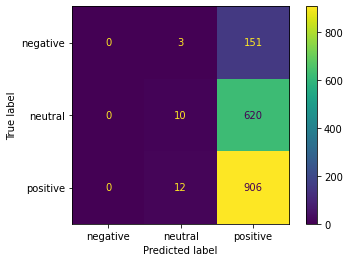

In [16]:
history_multiple_OL, score = run_and_evaluate_cnn('multiple-OL-cnn', mvsa_multiple_images, mvsa_multiple_image_labels, verbose=1)

## With multimodal labels

In [17]:
# history_single_ML, score = run_and_evaluate_cnn('single-ML-cnn', mvsa_single_images, mvsa_single_multimodal_labels, verbose=1)

Epoch 1/100
107/107 [==============================] - 13s 109ms/step - loss: 24.3064 - accuracy: 0.6322 - f1_macro: 0.3285 - f1_weighted: 0.5604 - val_loss: 0.9270 - val_accuracy: 0.7262 - val_f1_macro: 0.2805 - val_f1_weighted: 0.6125

Epoch 00001: val_loss improved from inf to 0.92703, saving model to ./model_checkpoint/multiple-ML-cnn.h5
Epoch 2/100
107/107 [==============================] - 12s 108ms/step - loss: 0.9054 - accuracy: 0.6604 - f1_macro: 0.2699 - f1_weighted: 0.5287 - val_loss: 0.8069 - val_accuracy: 0.7274 - val_f1_macro: 0.2807 - val_f1_weighted: 0.6131

Epoch 00002: val_loss improved from 0.92703 to 0.80686, saving model to ./model_checkpoint/multiple-ML-cnn.h5
Epoch 3/100
107/107 [==============================] - 11s 107ms/step - loss: 0.8452 - accuracy: 0.6614 - f1_macro: 0.2722 - f1_weighted: 0.5307 - val_loss: 0.7545 - val_accuracy: 0.7274 - val_f1_macro: 0.2824 - val_f1_weighted: 0.6142

Epoch 00003: val_loss improved from 0.80686 to 0.75451, saving model to 

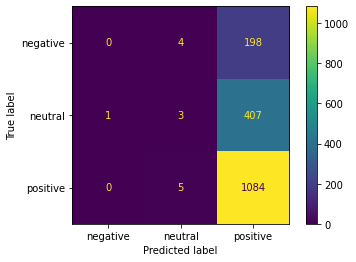

In [18]:
history_multiple_ML, score = run_and_evaluate_cnn('multiple-ML-cnn', mvsa_multiple_images, mvsa_multiple_multimodal_labels, verbose=1)

## With merge MVSA data

In [19]:
# history_OL, score = run_and_evaluate_cnn('OL-cnn', mvsa_images, mvsa_image_labels, verbose=1)

In [20]:
# history_ML, score = run_and_evaluate_cnn('ML-cnn', mvsa_images, mvsa_multimodal_labels, verbose=1)

# Drafts

In [21]:
# datagen = ImageDataGenerator(
#         shear_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         validation_split=0.1)

# single_train_set = datagen.flow(
#         mvsa_single_images, mvsa_single_image_labels,
# #         target_size=IMAGE_SIZE,
# #         batch_size=BATCH_SIZE,
# #         class_mode='categorical', 
#         subset='training')

# single_test_set = datagen.flow(
#         mvsa_single_images, mvsa_single_image_labels,
#         subset='validation')

# X_train, X_val, X_test = split_data(mvsa_single_images, VALIDATION_SPLIT)
# y_train, y_val, y_test = split_data(mvsa_single_multimodal_labels, VALIDATION_SPLIT)

# train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
# val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
# test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# del X_train, X_val, X_test, y_train, y_val, y_test

# data_path_single = '../input/mvsasingle/MVSA_Single/data/'

# BATCH_SIZE = 32
# EPOCHS = 10
# IMAGE_SIZE = np.array([224, 224])

# datagen = ImageDataGenerator(
#         shear_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         validation_split=0.1)

# train_set = datagen.flow_from_directory(
#         data_path_single, classes=['0', '1', '2'],
#         target_size=IMAGE_SIZE,
#         batch_size=BATCH_SIZE,
#         class_mode='categorical', subset='training')

# # valid_set = datagen.flow_from_directory(
# #         data_path_single,
# #         target_size=IMAGE_SIZE,
# #         batch_size=BATCH_SIZE,
# #         class_mode='categorical',
# #         subset='validation')

In [22]:
# mvsa_single_images =  np.load('../input/mvsa-data/mvsa-single-4511-images.npz')['arr_0']
# mvsa_multiple_images =  np.load('../input/mvsa-data/mvsa-multiple-17024-images.npz')['arr_0']

# mvsa_single_images = tf.data.Dataset.from_tensor_slices((mvsa_single_images, mvsa_single_multimodal_labels)).batch(128)
# mvsa_multiple_images = tf.data.Dataset.from_tensor_slices((mvsa_multiple_images, mvsa_multiple_multimodal_labels)).batch(128)
# mvsa_images = mvsa_single_images.concatenate(mvsa_multiple_images).batch(128)

#     if name == 'cnn':
#         data = []#load_mvsa_images()]
# #         x1 =  np.load('../input/mvsa-data/mvsa-single-4511-images.npz')['arr_0']
#         x1 = tf.data.Dataset.from_tensor_slices((np.load('../input/mvsa-data/mvsa-single-4511-images.npz')['arr_0'], mvsa_single_multimodal_labels))#.batch(128)
#         data.append(x1)

# #         x2 =  np.load('../input/mvsa-data/mvsa-multiple-17024-images.npz')['arr_0']
#         x2 = tf.data.Dataset.from_tensor_slices((np.load('../input/mvsa-data/mvsa-multiple-17024-images.npz')['arr_0'], mvsa_multiple_multimodal_labels))#.batch(128)
#         data.append(x2)
        
#         merge_data = x1.concatenate(x2)#.batch(128)
#         del x1, x2

# # prepare all features data
# feature_names = ['xception', 'vgg16', 'vgg19', 'resnet50', 'resnet101', 'resnet152', 'densenet121', 'densenet169', 'densenet201']

# mvsa_single_features = []
# mvsa_multiple_features = []
# mvsa_features = []

# for name in tqdm(feature_names):
#     data = load_mvsa_feature(name)
#     merge_data = merge_mvsa(data[0], data[1])
    
#     mvsa_single_features.append(data[0])
#     mvsa_multiple_features.append(data[1])
#     mvsa_features.append(merge_data)

# # load separate
# mvsa_single_images, mvsa_multiple_images = load_mvsa_images()
# mvsa_single_xception, mvsa_multiple_xception = load_mvsa_feature('xception')
# mvsa_single_vgg16, mvsa_multiple_vgg16 = load_mvsa_feature('vgg16')
# mvsa_single_vgg19, mvsa_multiple_vgg19 = load_mvsa_feature('vgg19')
# mvsa_single_resnet50, mvsa_multiple_resnet50 = load_mvsa_feature('resnet50')
# mvsa_single_resnet101, mvsa_multiple_resnet101 = load_mvsa_feature('resnet101')
# mvsa_single_resnet152, mvsa_multiple_resnet152 = load_mvsa_feature('resnet152')
# mvsa_single_densenet121, mvsa_multiple_densenet121 = load_mvsa_feature('densenet121')
# mvsa_single_densenet169, mvsa_multiple_densenet169 = load_mvsa_feature('densenet169')
# mvsa_single_densenet201, mvsa_multiple_densenet201 = load_mvsa_feature('densenet201')

# # load merge
# mvsa_images = merge_mvsa(mvsa_single_images, mvsa_multiple_images)
# mvsa_xception = merge_mvsa(mvsa_single_xception, mvsa_multiple_xception)
# mvsa_vgg16 = merge_mvsa(mvsa_single_vgg16, mvsa_multiple_vgg16)
# mvsa_vgg19 = merge_mvsa(mvsa_single_vgg19, mvsa_multiple_vgg19)
# mvsa_resnet50 = merge_mvsa(mvsa_single_resnet50, mvsa_multiple_resnet50)
# mvsa_resnet101 = merge_mvsa(mvsa_single_resnet101, mvsa_multiple_resnet101)
# mvsa_resnet152 = merge_mvsa(mvsa_single_resnet152, mvsa_multiple_resnet152)
# mvsa_densenet121 = merge_mvsa(mvsa_single_densenet121, mvsa_multiple_densenet121)
# mvsa_densenet169 = merge_mvsa(mvsa_single_densenet169, mvsa_multiple_densenet169)
# mvsa_densenet201 = merge_mvsa(mvsa_single_densenet201, mvsa_multiple_densenet201)

# # prepare all features data
# feature_names = ['cnn', 'xception', 'vgg16', 'vgg19', 'resnet50', 'resnet101', 'resnet152', 'densenet121', 'densenet169', 'densenet201']

# mvsa_single_features = [mvsa_single_images,
#                         mvsa_single_xception,
#                         mvsa_single_vgg16, mvsa_single_vgg19, 
#                         mvsa_single_resnet50, mvsa_single_resnet101, mvsa_single_resnet152, 
#                         mvsa_single_densenet121, mvsa_single_densenet169, mvsa_single_densenet201]

# mvsa_multiple_features = [mvsa_multiple_images,
#                           mvsa_multiple_xception,
#                           mvsa_multiple_vgg16, mvsa_multiple_vgg19, 
#                           mvsa_multiple_resnet50, mvsa_multiple_resnet101, mvsa_multiple_resnet152, 
#                           mvsa_multiple_densenet121, mvsa_multiple_densenet169, mvsa_multiple_densenet201]

# mvsa_features = [mvsa_images,
#                  mvsa_xception,
#                  mvsa_vgg16, mvsa_vgg19, 
#                  mvsa_resnet50, mvsa_resnet101, mvsa_resnet152, 
#                  mvsa_densenet121, mvsa_densenet169, mvsa_densenet201]